In [1]:
import pickle
from copy import deepcopy

import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout

import numpy as np; np.set_printoptions(suppress=True, linewidth=180)
import pandas as pd; pd.set_option('display.width', 500)
import matplotlib.pyplot as plt

from scipy.optimize import minimize


from plot_module import plot_ODE, plot_gillespie, plot_simulator_graph, plot_neuron_graph
from sim_param_from_network import names_from_network, gillespie_param_from_network, dataframes_from_network, ODE_from_network, start_state_from_nodes
from network_generate import net_gen_line_chain, net_gen_line_ring, net_gen_line_powlawtree, net_gen_hub_ring
from neuron_graph_transform import neuron_graph_transform, add_bioparam_attributes
from simulate import simulate_ode, simulate_gillespie
from graph_flow_solve import solve_fluxes

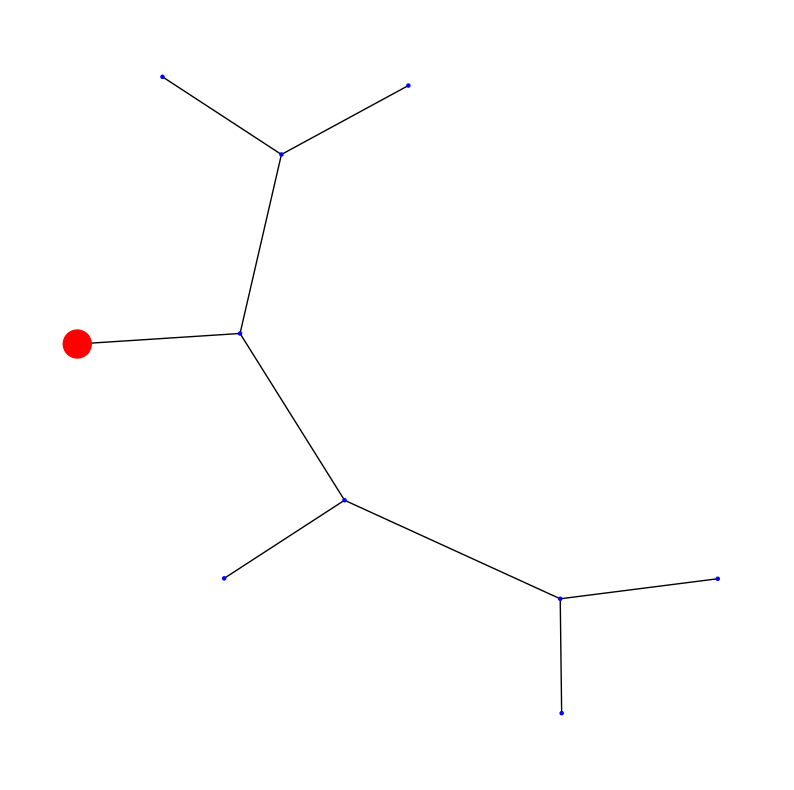

In [2]:
neuron_filename = 'm_hippocampus_NMO_97827.pkl'
with open(f'neuron_shape_data/{neuron_filename}', 'rb') as f:
    G = pickle.load(f)    
G.remove_node('319')

plot_neuron_graph(G)

In [3]:
SOMA_CB = 1.0
SOMA_BR = 3.2
SOMA_NSS = 100
SOMA_DIFFUSION = 0.4

DELTA = 0.5
DEATH_RATE = 0.4

AXON_TRNSP_ANT = 8
AXON_TRNSP_RET = 6

SWITCH_RATE_AR = 0.01
SWITCH_RATE_RA = 0.01


BIO_PARAM = {
    'soma_cb':SOMA_CB, 
    'soma_br':SOMA_BR, 
    'soma_nss':SOMA_NSS,
    'soma_diffusion':SOMA_DIFFUSION,
    
    'delta':DELTA, 
    'death_rate':DEATH_RATE, 
    
    'gamma_ant':AXON_TRNSP_ANT,
    'gamma_ret':AXON_TRNSP_RET,
    
    'switch_rate_ar':SWITCH_RATE_AR,
    'switch_rate_ra':SWITCH_RATE_RA,
    }

START_POP = [90, 20]

In [4]:
neuron_graph = neuron_graph_transform(G, transform_type='bidirect', n_soma_nodes=1)
neruon_graph = add_bioparam_attributes(neuron_graph, BIO_PARAM)

#for u, v, data in neuron_graph.edges(data = True): print(f'{u}-{v}: {data}')
#for node, data in neuron_graph.nodes(data = True): print(f'{node}: {data}')

G = deepcopy(neuron_graph)

> The undirected input graph has 10 nodes, and 9 edges, and 1 subgraph(s):
'axon with 9 nodes'
> the directed output graph has 10 nodes, and 18 edges


In [8]:
N = G.number_of_nodes()
steady_state_pop = np.full(N, 100)

steady_state_flux = steady_state_pop*DEATH_RATE
steady_state_flux[0] = 0

flux_dict = solve_fluxes(G, BIO_PARAM, steady_state_pop, steady_state_flux)

> Flux dataframe:
            (u, v)    reverse_pair flux_mat_i_j  specified_rate unknown_name
0     (S0B, A116B)    (A116B, S0B)       (0, 1)             NaN         x[0]
1   (A116B, A165B)  (A165B, A116B)       (1, 2)             NaN         x[1]
2   (A116B, A187B)  (A187B, A116B)       (1, 5)             NaN         x[2]
3     (A116B, S0B)            None       (1, 0)             NaN         x[3]
4   (A165B, A116B)            None       (2, 1)             NaN         x[4]
5   (A165B, A174B)  (A174B, A165B)       (2, 3)             0.8         None
6   (A165B, A181B)  (A181B, A165B)       (2, 4)             0.8         None
7   (A174B, A165B)            None       (3, 2)             0.4         None
8   (A181B, A165B)            None       (4, 2)             0.4         None
9   (A187B, A116B)            None       (5, 1)             NaN         x[5]
10  (A187B, A208B)  (A208B, A187B)       (5, 6)             0.8         None
11  (A187B, A221B)  (A221B, A187B)       (5, 7)           

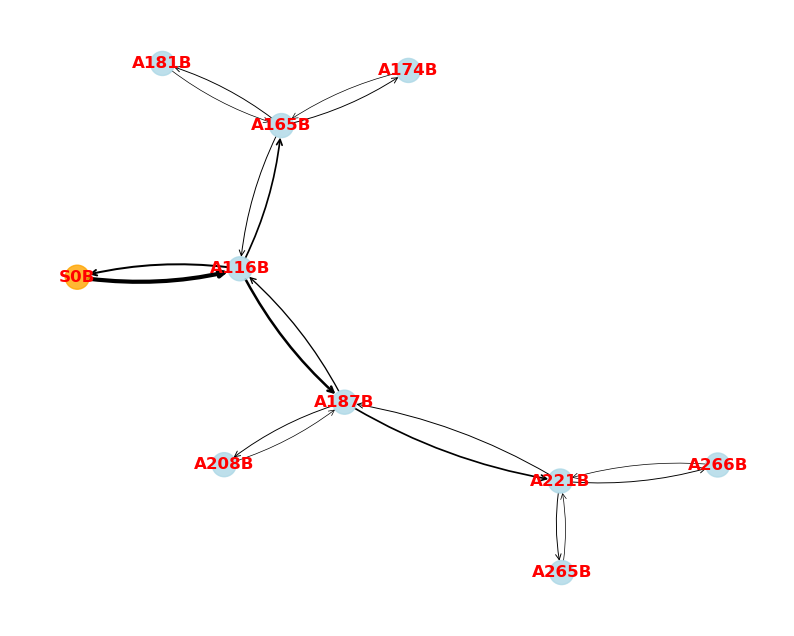

In [9]:
# update rates
nx.set_edge_attributes(G, flux_dict, 'rate')
plot_simulator_graph(G)

In [10]:
TIME_POINTS = np.linspace(0, 1000, 1001)
VARS, NODES = names_from_network(G)
START_STATE = start_state_from_nodes(NODES, [90,20])

>> Code for ODE model:

global ODE_model
def ODE_model(t, z):
	# variables (node name + wt/mt)
	S0B_wt, S0B_mt, A116B_wt, A116B_mt, A165B_wt, A165B_mt, A174B_wt, A174B_mt, A181B_wt, A181B_mt, A187B_wt, A187B_mt, A208B_wt, A208B_mt, A221B_wt, A221B_mt, A265B_wt, A265B_mt, A266B_wt, A266B_mt = z
	return [
		# ΔS0B_wt/Δt
		(S0B_wt*((3.2 + 1.0*(100-S0B_wt-(0.5*S0B_mt)))-(0.4)-(6.1715)))+(A116B_wt*2.5715),
		# ΔS0B_mt/Δt
		(S0B_mt*((3.2 + 1.0*(100-S0B_wt-(0.5*S0B_mt)))-(0.4)-(6.1715)))+(A116B_mt*2.5715),
		# ΔA116B_wt/Δt
		(A116B_wt*(0-(0.4)-(8.0574)))+(S0B_wt*6.1715)+(A165B_wt*0.8572)+(A187B_wt*1.4287),
		# ΔA116B_mt/Δt
		(A116B_mt*(0-(0.4)-(8.0574)))+(S0B_mt*6.1715)+(A165B_mt*0.8572)+(A187B_mt*1.4287),
		# ΔA165B_wt/Δt
		(A165B_wt*(0-(0.4)-(2.4572)))+(A116B_wt*2.0572)+(A174B_wt*0.4)+(A181B_wt*0.4),
		# ΔA165B_mt/Δt
		(A165B_mt*(0-(0.4)-(2.4572)))+(A116B_mt*2.0572)+(A174B_mt*0.4)+(A181B_mt*0.4),
		# ΔA174B_wt/Δt
		(A174B_wt*(0-(0.4)-(0.4)))+(A165B_wt*0.8),
		# ΔA174B_mt/Δt
		(A174B_mt*(0-(

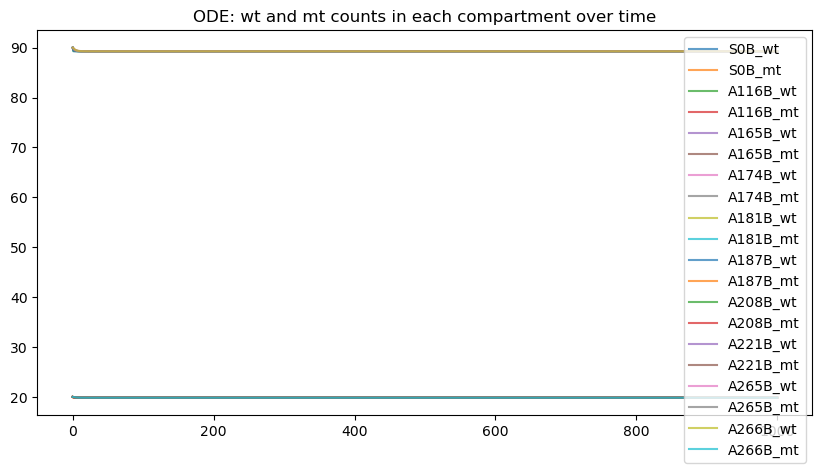

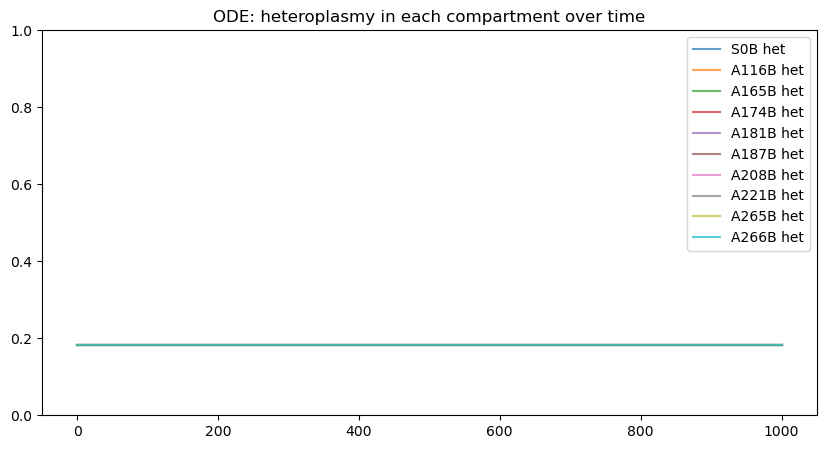

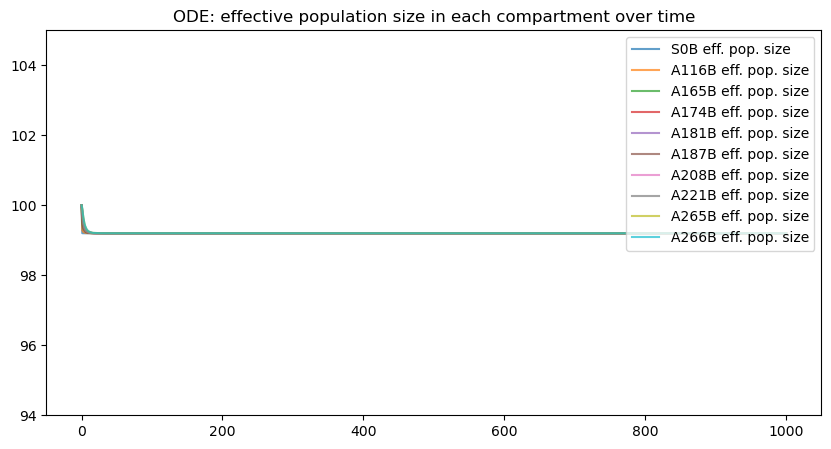

> Final counts of mt and wt in each compartment:
S0B_wt	89.28	
S0B_mt	19.84	
A116B_wt	89.28	
A116B_mt	19.84	
A165B_wt	89.28	
A165B_mt	19.84	
A174B_wt	89.28	
A174B_mt	19.84	
A181B_wt	89.28	
A181B_mt	19.84	
A187B_wt	89.28	
A187B_mt	19.84	
A208B_wt	89.28	
A208B_mt	19.84	
A221B_wt	89.28	
A221B_mt	19.84	
A265B_wt	89.28	
A265B_mt	19.84	
A266B_wt	89.28	
A266B_mt	19.84	

> Final effective population sizes in each compartment:
S0B	99.2	
A116B	99.2	
A165B	99.2	
A174B	99.2	
A181B	99.2	
A187B	99.2	
A208B	99.2	
A221B	99.2	
A265B	99.2	
A266B	99.2	


In [11]:
ODE_model = ODE_from_network(G, prnt=True)
plot_ODE(simulate_ode(ODE_model, TIME_POINTS, START_STATE), TIME_POINTS, DELTA, VARS, NODES)

simulating...


100%|██████████| 1000/1000 [04:33<00:00,  3.66it/s]


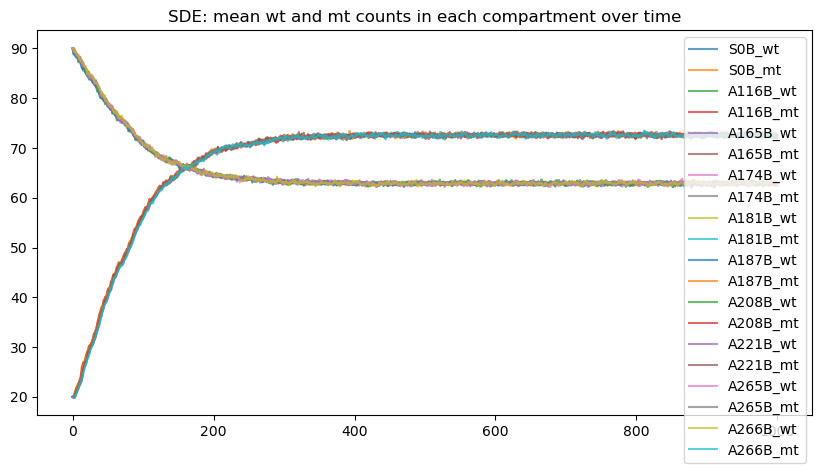

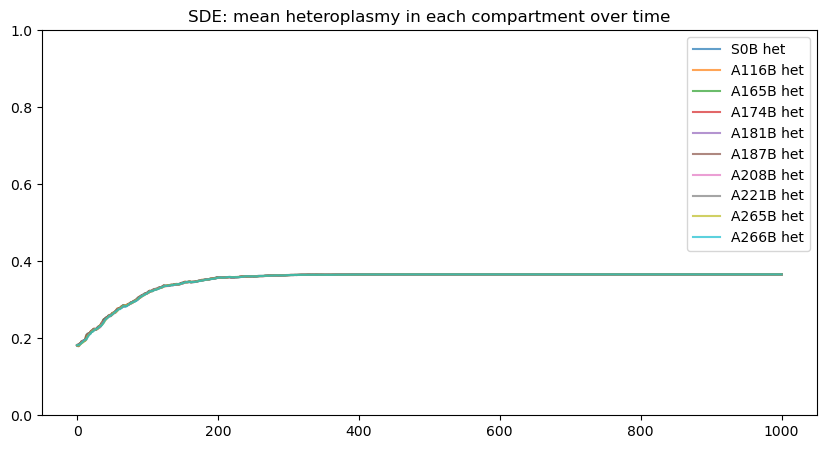

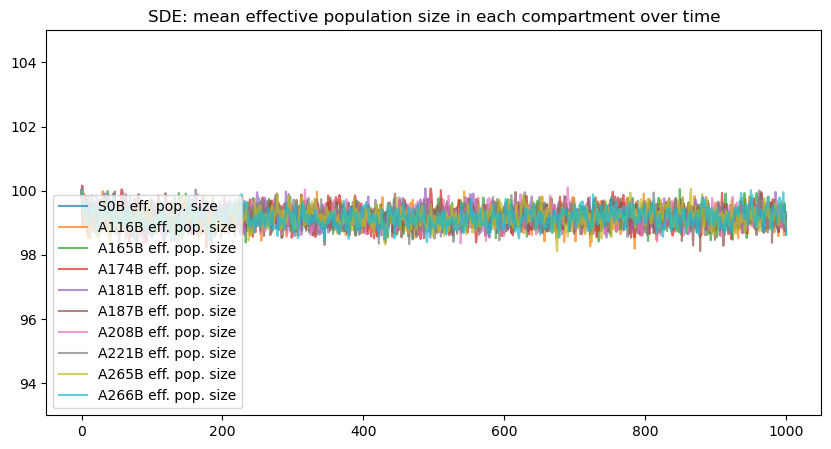

> Final mean counts of mt and wt in each compartment:
S0B_wt	62.902	
S0B_mt	72.628	
A116B_wt	62.826	
A116B_mt	72.687	
A165B_wt	62.971	
A165B_mt	72.698	
A174B_wt	62.756	
A174B_mt	72.411	
A181B_wt	62.805	
A181B_mt	72.447	
A187B_wt	62.355	
A187B_mt	72.574	
A208B_wt	62.912	
A208B_mt	72.624	
A221B_wt	62.637	
A221B_mt	72.258	
A265B_wt	62.647	
A265B_mt	72.47	
A266B_wt	62.505	
A266B_mt	72.236	

> Final mean heteroplasmy in each compartment:
S0B	0.366	
A116B	0.366	
A165B	0.366	
A174B	0.366	
A181B	0.366	
A187B	0.366	
A208B	0.366	
A221B	0.366	
A265B	0.366	
A266B	0.366	

> Final mean effective population sizes in each compartment:
S0B	99.216	
A116B	99.1695	
A165B	99.32	
A174B	98.9615	
A181B	99.0285	
A187B	98.642	
A208B	99.224	
A221B	98.766	
A265B	98.882	
A266B	98.623	

> Change in mean heteroplasmy: 
start: 0.1818
final: 0.3662
delta: 0.1844


In [12]:
GILL_PARAM = gillespie_param_from_network(G)
gillespie_results = simulate_gillespie(GILL_PARAM, TIME_POINTS, START_STATE, replicates=1000)
plot_gillespie(gillespie_results, TIME_POINTS, DELTA, VARS, NODES)